# Predicting Student Performance

## Introduction

After reading a bit about machine learning and predictive modeling, I wanted to use some of these models and get some hands-on practice. I decided to try and predict student performance, namely final scores in a class, using data about Portuguese secondary students found on UCI's machine learning repository. I figured that this topic would be somewhat relevant to me since I work in the education sector.

There are two datasets available on the machine learning repository: one with scores from a math course, another with scores from a Portuguese course. I will focus on the dataset with the Portuguese course scores. The dataset is very clean, and while I recognize that real data is never this clean, I wanted to spend more time on applying machine learning techniques than on cleaning data. 

More information on the data can be found [here](https://archive.ics.uci.edu/ml/datasets/student+performance#).


## Setup

Import libraries:

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

%matplotlib inline

Read in the data:

In [3]:
student_data = pd.read_csv("data/student-por.csv", sep=";")
print(student_data.dtypes)

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object


## Exploratory Data Analysis

Since this dataset is fairly small, I use the `pandas_profiling` library to produce a profile report. This is a very convenient tool for conducting quick exploratory data analyses. While the output can be displayed in the notebook, doing so makes the notebook larger than it needs to be, so it's saved as a separate HTML file instead. This is more readable/accessible anyway.

In [3]:
profile = ProfileReport(student_data, title="Student Data Profile Report")
profile.to_file("student_data_profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


Some quick insights from the profile report:
* There are 649 records and 33 variables in the data.

* The dataset has students from two schools: "Gabriel Pereira" and "Mousinho da Silveria". The majority of the students (~65%) attend school at "Mousinho de Silveria".

* Most of the students (~70%) have an urban address (as opposed to a rural address). My guess is that one of the schools is closer to an urban area while the other is closer to a rural area, and that there is a relationship between a student's address type and the school the student goes to. Proximity to a school is usually an important factor when considering school options.

* Only around 50% of students participated in extracurricular activities. I expected more students to be engaging in extracurricular activities, but my perspective might be skewed by my own experiences. It's also possible that there's some sort of cultural or philosophical difference between the Portuguese and American education systems.

* Unsurprisingly, the first period grade (G1), second period grade (G2), and final grade (G3) are all highly correlated with each other. A student's past grades within a course are often strong predictors of the final grade for that course, and it looks like the data here is no exception. 

* There is no missing data across the 33 variables in the dataset.

## Data Preprocessing

I start by converting all the categorical variables to numeric 0/1. In some cases, I create dummy variables and in others I simply recode the variables. After that, I standardize the numeric variables (age and absences) since their scales are pretty different. 

In [4]:
# get dummy variables
vars_to_dummy = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "Medu", "Fedu", "reason", "guardian"]
student_data = pd.get_dummies(student_data, prefix=vars_to_dummy, columns=vars_to_dummy)

# recode yes as 1 and no as 0
student_data = student_data.replace({"yes": 1, "no": 0})

# standardize age and absences
student_data[["age", "absences"]] = StandardScaler().fit_transform(student_data[["age", "absences"]])

Now I split my data into train and test sets after I drop the G1 and G2 variables. My goal is to predict G3 (the final grade), and I have no doubt that previous grades in the class (G1 and G2) would be very predictive of G3. However, I think it would be more interesting to try and predict G3 without G1 and G2, even if the models will perform worse.

In [5]:
# drop G1 and G2
student_data.drop(columns=["G1", "G2"], inplace=True)

# split data into train and test sets
Xs = student_data.drop(columns=["G3"])
y = student_data["G3"]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=99)

## Preliminary Models



There are three methods that I want to try out in this exercise:

1. Random Forest
2. Support Vector Regression
3. Elastic Net

All models will be evaluated using the root mean squared error (RMSE) metric.

Before I do anything else, I'll define a simple function to display relevant metrics when evaluating models.

In [6]:
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### 1. Random Forest

A random forest is an ensemble of decision trees; it's essentially a collection of decision trees where each tree is slightly different. The idea here is to average the results of many trees to reduce the overfitting that occurs when using trees individually while retaining the predictive power of the trees. The randomness comes in two ways: the random data points used to build a tree and the random features selected in each split test. By default, Scikit-Learn sets the number of trees to be 100 for the random forest regressor.

When doing 10-fold cross validation with the default parameters, the mean RMSE of the random forest model is ~2.64.

In [7]:
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Mean: 2.6445176212933346
Standard deviation: 0.3024847093441134


### 2. Support Vector Regression

Support vector machines were traditionally developed in the context of classification, but it turned out that this technique could also be extended to regression. There are different types of support vector regression, but the most common version is the ε-insensitive regression. The goal is to fit as many points within a user defined margin (ε) and then fitting a line based on the points that fall on or outside the margin (the support vectors). SVR can also be used for nonlinear regression by applying a kernel. Scikit-Learn uses a radial basis function kernel by default.

The mean RMSE of the SVR model with default parameters is ~2.73.

In [8]:
svr = SVR()
svr_scores = cross_val_score(svr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Mean: 2.730956975172
Standard deviation: 0.4492464899050872


### 3. Elastic Net

The elastic net is a linear regression model that combines L1 and L2 regularization. L1 and L2 are penalties added to the ordinary least squares regression equation in order to constrain the magnitude of the coefficents. This helps prevent the model from overfitting and, in the case of L1 regularization, perform feature selection. Since elastic net incorporates both penalties, it can end up using just the L1 penalty, just the L2 penalty, or something in between.

The mean RMSE of the elastic net model with default parameters is ~3.04.

In [9]:
elastic_net = ElasticNet()
elastic_net_scores = cross_val_score(elastic_net, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
elastic_net_rmse_scores = np.sqrt(-elastic_net_scores)
display_scores(elastic_net_rmse_scores)

Mean: 3.0374281663856157
Standard deviation: 0.5367611257956088


## Hyperparameter Tuning

After fitting the models to the training data using default parameters, it seems that the random forest model has the lowest mean RMSE. However, before I evaluate the models using the test data, I want to tune my models and figure out which hyperparameters will yield the best results. I'm also curious how this will affect the RMSE of the different models.

Similar to before, I start by defining a function that will display the best score and parameter after tuning the hyperparameters.

In [31]:
def display_best_score(search_result):
    print("Best score:", np.sqrt(-search_result.best_score_))
    print("Best parameters:", search_result.best_params_)

Using an exhaustive grid search, the best score is ~2.62 and the best parameters are max_depth = 20, max_features = auto, min_samples_leaf = 2, min_samples_split = 4, and n_estimators = 50. This is a ~0.02 point improvement over the default model. There were a lot of hyperparameters to test so it ended up taking 49 minutes for the grid search to run. In the future, it might be better to search over fewer parameters or use a randomized search.

In [96]:
%%time
# tuning random forest
rf_param_grid = {
    "n_estimators": [10, 50, 100, 150, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_leaf": [1, 2, 4, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 8, 10]
}
rf_random_search = GridSearchCV(forest_reg, rf_param_grid, cv=10, scoring="neg_mean_squared_error")
rf_random_search.fit(X_train, y_train)
display_best_score(rf_random_search)

Best score: 2.6162904995051033
Best parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50}
Wall time: 49min 38s


It's possible to look at the importance of features for a random forest model. A feature's importance is calculated based on how much the tree nodes that use this feature reduce impurity on average (across all trees in the forest). Nodes are also weighted based on the number of training samples associated with it. When I plot the top 10 important features of my random forest model, `failures` is the most important feature by far with `absences` a distant second. This is not surprising to me at all. Others have noted that feature importance based on impurity can be biased since it is computed on statistics derived from the training data and suggest looking at permutation importances to mitigate these limitations. However, I think the top two most important features will still be `failures` and `absences` regardless. 

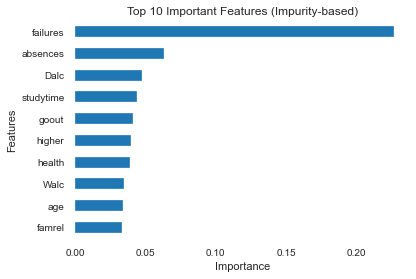

In [97]:
# plot top 10 important features (impurity-based)
sorted_idx = rf_random_search.best_estimator_.feature_importances_.argsort()
all_features = pd.DataFrame({
    "features": X_train.columns[sorted_idx], 
    "importance": rf_random_search.best_estimator_.feature_importances_[sorted_idx]
})
top10_features = all_features.sort_values("importance", ascending=False).head(10)

fig, ax = plt.subplots()
top10_features.sort_values("importance").plot(kind="barh", x="features", y="importance", ax=ax)
ax.set(title="Top 10 Important Features (Impurity-based)", xlabel="Importance", ylabel="Features")
ax.legend().set_visible(False)


After searching the hyperparameter space for the SVR model, the best score is ~2.71 and the best parameters are C = 10, epsilon = 1, and gamma = 0.01. This is a ~0.02 point improvement over the default model.

In [101]:
# tuning support vector regression (C, epsilon, gamma)
svr_param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "epsilon": [0, 0.01, 0.1, 0.5, 1, 2, 4]
}
svr_grid_search = GridSearchCV(svr, svr_param_grid, cv=10, scoring="neg_mean_squared_error")
svr_grid_search.fit(X_train, y_train)
display_best_score(svr_grid_search)

Best score: 2.7087091296844816
Best parameters: {'C': 10, 'epsilon': 1, 'gamma': 0.01}


Finally, for the elastic net, the best score is ~2.75 and the best parameters are alpha = 0.01 and l1_ratio = 1. This is a ~0.29 point improvement over the default model. It looks like the hyperparameter tuning is making the elastic net model far more performant. Note that the best l1_ratio here is 1, which means the model is only using the L1 penalty.

In [35]:
# tuning elastic net
elastic_param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 1, 10, 100],
    "l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
elastic_grid_search = GridSearchCV(elastic_net, elastic_param_grid, cv=10, scoring="neg_mean_squared_error")
elastic_grid_search.fit(X_train, y_train)
display_best_score(elastic_grid_search)


Best score: 2.7451279687924073
Best parameters: {'alpha': 0.01, 'l1_ratio': 1}


## Evaluate Final Models

Now that the models have been tuned, I can test the final models using the test data. The random forest model still has the best RMSE at ~2.85, though the SVR is not too far behind at 2.88. The elastic net model ends up with an RMSE of ~2.95.

In [98]:
def eval_model(model, x=X_test, y=y_test):
    predictions = model.predict(x)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [100]:
# random forest
final_rf = rf_random_search.best_estimator_

# svr
final_svr = svr_grid_search.best_estimator_

# elastic net
final_enet = elastic_grid_search.best_estimator_

print("Final random forest RMSE:", eval_model(final_rf))
print("Final SVR RMSE:", eval_model(final_svr))
print("Final elastic net RMSE:", eval_model(final_enet))

Final random forest RMSE: 2.850163880600298
Final SVR RMSE: 2.878404617950205
Final elastic net RMSE: 2.952708972578548


## Conclusion and Reflection

Overall, the models don't seem all that great. The random forest model had the lowest RMSE at ~2.85, which means on average, the model predictions were off by ~2.85 points. This is a lot considering the scale of the final grade is only 0 to 20. Granted, my implementation is certainly not perfect and there are probably better ways or methods to go about predicting student performance. If I were interested in model performance alone, I would have also included the first period and second period grades as predictors. This would no doubt improve the performance of all the models. 

I do also wonder about the practical use of these models and the act of predicting student performance itself. The first thing that comes to mind is intervention and targeted supports for students in danger of failing the class or doing poorly. The question then is would using these predictive models be any better than a teacher simply looking at students' past grades and determining who needs more help. I'm not so sure that would be the case. I think there is potential in using these models to help automate targeted supports, but it would have to be very carefully implemented. 

This was a fun exercise and I enjoyed diving into a machine learning task, even if it was a fairly simple and imperfect application. It took me longer than I expected because I ended up Googling and rereading a lot of things and second guessing myself. It turns out that reading about machine learning and predictive modeling is not that the same as applying the concepts. Who would have thought? The hyperparameter tuning was particularly time consuming, both theoretically and computationally. I wasn't really sure which numbers or how many numbers to include in the parameter grid and I'd love to develop some sort of intution about these things. 